Evaluation Metrics on Unseen Test Data:
             Metric  Value
           Test MSE  25.01
            Test R²   0.78
Regression Accuracy 77.51%


Index,Data Tag,Pre-load,ANN Predicted Stress
1,ali2023evaluation_DRA2_green,30.00,23.41
2,attar2014investigating_plastic_b_1,35.00,25.48
3,attar2014investigating_linear_a_3,8.00,9.67
4,ali2023evaluation_DRA1_red,15.00,14.20
5,attar2014investigating_crack_b_1,3.50,5.52
6,attar2014investigating_crack_b_2,3.50,5.88
7,ali2023evaluation_DRA1_black,7.50,8.32
8,wang2024triaxial_DRA2_3,30.00,33.05
9,ali2023evaluation_DRA2_blue,22.50,21.10
10,attar2014investigating_linear_b_1,14.00,13.28


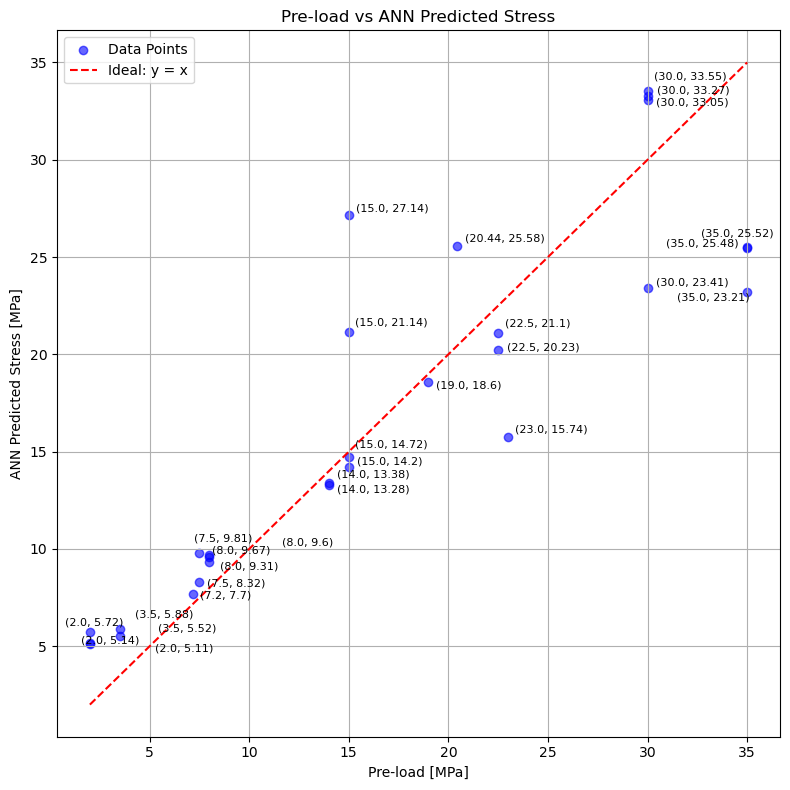

In [4]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

# ----------------------------
# User-defined Configuration
# ----------------------------
#Input the name of ANN model which will be used for prediction
model_name = "ANNxCPAExampleModelName"    #Do not include ".pkl"

#Input the name of the CSV file containing CPA data
filename = "cpaResultsTestingData"    #Do not include ".csv"



# ----------------------------
# Loading ANN Model
# ----------------------------
MODEL_FILE = f"{model_name}.pkl"
with open(MODEL_FILE, "rb") as f:
    model_data = pickle.load(f)

best_layers = model_data["layers"]
scaler = model_data["scaler"]
PREDICTORS = model_data["predictors"]
TARGET = model_data["target"]


# ----------------------------
# Load and Preprocess Test Data
# ----------------------------
TEST_DATA_FILE = f"{filename}.csv"
test_data = pd.read_csv(TEST_DATA_FILE).dropna()
#Shuffles testing data
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Applying the saved scaler to the predictor columns.
test_data[PREDICTORS] = scaler.transform(test_data[PREDICTORS])
test_x = test_data[PREDICTORS].to_numpy()
test_y = test_data[[TARGET]].to_numpy()


# ----------------------------
# Define Forward Function and Evaluation Metrics
# ----------------------------
def forward(batch, layers):
    hiddens = [batch.copy()]
    for i in range(len(layers)):
        batch = np.matmul(batch, layers[i][0]) + layers[i][1]
        if i < len(layers) - 1:
            batch = np.maximum(batch, 0)
        hiddens.append(batch.copy())
    return batch, hiddens

def mse(actual, predicted):
    return (actual - predicted) ** 2

def compute_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot if ss_tot != 0 else 1.0

def regression_accuracy(predicted, actual):
    accs = []
    for p, a in zip(predicted, actual):
        if a == 0 and p == 0:
            acc = 100
        elif a == 0:
            acc = 0
        else:
            acc = (min(p, a) / max(p, a)) * 100
        accs.append(acc)
    return np.mean(accs)


# ----------------------------
# Functions plotting results
# ----------------------------
def create_table(data_tags, preLoad, predicted, title="My Table Title"):
    """
    Creates a table with 4 columns: Index, Data Tag, pre-load, ANN Predicted Stress.
    
    Parameters:
      data_tags: List of dataTag values.
      preLoad: List of the pre-load values.
      predicted: List of the ANN predicted stress values.
      title: Title for the table (default "My Table Title").
    
    Returns:
      A styled pandas DataFrame displaying the table.
    """
    # Check that all input lists have the same length.
    if not (len(data_tags) == len(preLoad) == len(predicted)):
        raise ValueError("All input lists must have the same length.")
    
    # Generate a list of indices (starting at 1)
    indices = list(range(1, len(data_tags) + 1))
    
    # Create a dictionary for the table data.
    data = {
        "Index": indices,
        "Data Tag": data_tags,
        "Pre-load": preLoad,
        "ANN Predicted Stress": predicted,
    }
    
    # Create a pandas DataFrame from the dictionary.
    df = pd.DataFrame(data)
    
    # Hide the default DataFrame index (0 to n-1) so only the custom "Index" column is displayed.
    styled_table = df.style.hide(axis="index").set_caption(title).format({
        "Pre-load": "{:.2f}",
        "ANN Predicted Stress": "{:.2f}"
    })
    
    return styled_table

def plot_preLoad_vs_prediction(preLoad, predicted, title="Pre-load vs ANN Predicted Stress"):
    """
    Plots a scatter plot of pre-load stress vs predicted stress and overlays a y=x line.
    
    Parameters:
      preLoad: List or array of pre-load stress values.
      predicted: List or array of ANN predicted stress values.
      title: Title for the plot (default "Pre-load vs ANN Predicted Stress").
    """
    plt.figure(figsize=(8, 8))
    
    # Create scatter plot
    plt.scatter(preLoad, predicted, color='blue', alpha=0.6, label='Data Points')
    
    # Create and store text annotations.
    texts = []
    for p, a in zip(preLoad, predicted):
        texts.append(plt.text(p, a, f'({p}, {round(a,2)})', fontsize=8, ha='left', va='bottom'))
    
    # Adjust text to prevent overlapping.
    adjust_text(texts, verbose=0)
    
    # Determine min and max for plotting the ideal y=x line.
    min_val = min(min(preLoad), min(predicted))
    max_val = max(max(preLoad), max(predicted))
    
    # Plot the ideal y=x line.
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: y = x')
    
    # Add labels and title.
    plt.xlabel("Pre-load [MPa]")
    plt.ylabel("ANN Predicted Stress [MPa]")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return 

# ----------------------------
# Run Model on Test Data and Evaluate
# ----------------------------
test_preds, _ = forward(test_x, best_layers)
test_mse_val = np.mean(mse(test_y, test_preds))
test_r2_val = compute_r2(test_y.flatten(), test_preds.flatten())
test_reg_acc = regression_accuracy(test_preds.flatten(), test_y.flatten())

# Display evaluation metrics in a table.
metrics_df = pd.DataFrame({
    "Metric": ["Test MSE", "Test R²", "Regression Accuracy"],
    "Value": [f"{test_mse_val:.2f}", f"{test_r2_val:.2f}", f"{test_reg_acc:.2f}%"]
})
print("Evaluation Metrics on Unseen Test Data:")
print(metrics_df.to_string(index=False))

# Display pre-load vs. ANN predicted stress.
table = create_table(test_data["dataTag"], test_data[TARGET], test_preds.flatten(), title="Model Predictions on Unseen Test Data: Pre-load vs. ANN Predicted Stress")
display(table)
plot_preLoad_vs_prediction(test_data[TARGET], test_preds.flatten(), title="Pre-load vs ANN Predicted Stress")